In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import crystal_dd
import transform as mytrans

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platforms", 'cpu')


from ImageD11.parameters import AnalysisSchema
from ImageD11.columnfile import columnfile

%matplotlib widget

In [2]:
# set up detector

In [3]:
pars = AnalysisSchema.from_default().geometry_pars_obj
pars.set('tilt_x', 0.00123)
pars.set('tilt_y', -0.0345)
pars.set('tilt_z', 0.02)
pars.set('chi', 1)
pars.set('wedge', -3)
pars.set('t_x', 1)
pars.set('t_y', 2)
pars.set('t_z', 3)

In [4]:
pars.get('wavelength')

0.2845704

In [5]:
# make some g-vectors
# make some hkls first

In [6]:
import importlib
importlib.reload(crystal_dd)

<module 'crystal_dd' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/crystal_dd.py'>

In [7]:
struc = crystal_dd.structure.from_cif('ICSD_CollCode53807.cif')

In [8]:
# computes all rings, but we don't know the intensities yet
struc.make_hkls(dsmax=1.0, wavelength=pars.get('wavelength'))

In [9]:
struc.ringds

array([0.49205989, 0.56818182, 0.80353043, 0.94222295, 0.98411978])

In [10]:
struc.ringhkls

{0.49205988851388555: array([[-1., -1., -1.],
        [ 1.,  1.,  1.],
        [-1., -1.,  1.],
        [ 1.,  1., -1.],
        [-1.,  1.,  1.],
        [ 1., -1., -1.],
        [ 1., -1.,  1.],
        [-1.,  1., -1.]]),
 0.5681818181818182: array([[ 0.,  2.,  0.],
        [-2.,  0.,  0.],
        [ 0., -2.,  0.],
        [ 0.,  0., -2.],
        [ 2.,  0.,  0.],
        [ 0.,  0.,  2.]]),
 0.8035304331665312: array([[-2.,  2.,  0.],
        [-2.,  0., -2.],
        [ 2.,  0., -2.],
        [ 2.,  0.,  2.],
        [ 0.,  2., -2.],
        [ 0.,  2.,  2.],
        [-2., -2.,  0.],
        [-2.,  0.,  2.],
        [ 0., -2.,  2.],
        [ 2., -2.,  0.],
        [ 0., -2., -2.],
        [ 2.,  2.,  0.]]),
 0.9422229518055113: array([[-1., -3., -1.],
        [-1., -3.,  1.],
        [-3., -1.,  1.],
        [ 3., -1.,  1.],
        [ 3., -1., -1.],
        [ 3.,  1., -1.],
        [-3.,  1.,  1.],
        [-1.,  1., -3.],
        [ 1.,  1.,  3.],
        [-1.,  3.,  1.],
        [-1.,

In [11]:
struc.ringmult

array([ 8,  6, 12, 24,  8])

In [12]:
B = struc.B

In [13]:
from scipy.spatial.transform import Rotation as R
U_in = R.random(1).as_matrix()[0]

In [14]:
U_in

array([[-0.53975085,  0.84084002, -0.04070721],
       [ 0.61614293,  0.42753839,  0.6614974 ],
       [ 0.57361739,  0.33196232, -0.74884184]])

In [15]:
all_hkls = np.concatenate(list(struc.ringhkls.values()))

In [16]:
gve = (U_in @ B @ all_hkls.T).T

In [17]:
gve.shape

(58, 3)

In [18]:
# all we need to test indexing

In [19]:
# does ImageD11 index it?

In [20]:
import ImageD11.indexing
import ImageD11.unitcell
import ImageD11.grain

In [21]:
struc.lattice_parameters

(3.52, 3.52, 3.52, 90.0, 90.0, 90.0)

In [22]:
idx = ImageD11.indexing.indexer(unitcell=ImageD11.unitcell.unitcell(struc.lattice_parameters, int(struc._sym.spacegroup_number)),
                                gv=gve,
                                wavelength=pars.get('wavelength'))

info: gv: [[-0.07397215 -0.48442577 -0.0445278 ]
 [ 0.07397215  0.48442577  0.0445278 ]
 [-0.09710125 -0.10857498 -0.47000612]
 [ 0.09710125  0.10857498  0.47000612]
 [ 0.38064877  0.13434456 -0.28139117]
 [-0.38064877 -0.13434456  0.28139117]
 [-0.40377787  0.24150624 -0.14408715]
 [ 0.40377787 -0.24150624  0.14408715]
 [ 0.47775001  0.24291954  0.18861496]
 [ 0.30667662 -0.35008121 -0.32591897]
 [-0.47775001 -0.24291954 -0.18861496]
 [ 0.0231291  -0.3758508   0.42547832]
 [-0.30667662  0.35008121  0.32591897]
 [-0.0231291   0.3758508  -0.42547832]
 [ 0.78442663 -0.10716167 -0.13730401]
 [ 0.32980572 -0.72593201  0.09955935]
 [-0.28354752 -0.02576959  0.75139729]
 [-0.32980572  0.72593201 -0.09955935]
 [ 0.50087911 -0.13293126  0.61409328]
 [ 0.45462091  0.61877034 -0.23686336]
 [-0.17107339 -0.59300075 -0.51453393]
 [ 0.28354752  0.02576959 -0.75139729]
 [-0.50087911  0.13293126 -0.61409328]
 [-0.78442663  0.10716167  0.13730401]
 [-0.45462091 -0.61877034  0.23686336]
 [ 0.17107339  

In [23]:
idx.assigntorings()
idx.score_all_pairs()
grains = [ImageD11.grain.grain(ubi) for ubi in idx.ubis]
U_id11 = grains[0].U
print(U_id11)

info: Assign to rings, maximum d-spacing considered: 0.984120
info: Ring assignment array shape (58,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 4   ( -2, -2, -2)    8      8       0        8   N/A     N/A  16.10
info: Ring 3   ( -1, -3, -1)   24     24       0       24   N/A     N/A  15.41
info: Ring 2   ( -2,  0, -2)   12     12       0       12   N/A     N/A  13.13
info: Ring 1   (  0, -2,  0)    6      6       0        6   N/A     N/A  9.27
info: Ring 0   ( -1, -1, -1)    8      8       0        8   N/A     N/A  8.03
info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scoring matrix (58, 3)
info: Assign to rings, maximum d-spacing considered: 0.984120
info: Ring assignment array shape (58,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 4   ( -2, -2, -2)    8      8       0        8   N/A     N/A  16.10
info: Ring 3   ( -1, -3, -1)   2

In [24]:
U_id11, U_in

(array([[-0.53975085, -0.84084002,  0.04070721],
        [ 0.61614293, -0.42753839, -0.6614974 ],
        [ 0.57361739, -0.33196232,  0.74884184]]),
 array([[-0.53975085,  0.84084002, -0.04070721],
        [ 0.61614293,  0.42753839,  0.6614974 ],
        [ 0.57361739,  0.33196232, -0.74884184]]))

In [25]:
# make scattering vectors on the detector
(sc_one, fc_one), (sc_two, fc_two), (omega1, omega2) = mytrans.g_to_det(gve, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))),
                            pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                            pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                              pars.get('tilt_x'),
                              pars.get('distance'),
                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [26]:
sc = np.concatenate((sc_one, sc_two))
fc = np.concatenate((fc_one, fc_two))
omega = np.concatenate((omega1, omega2))

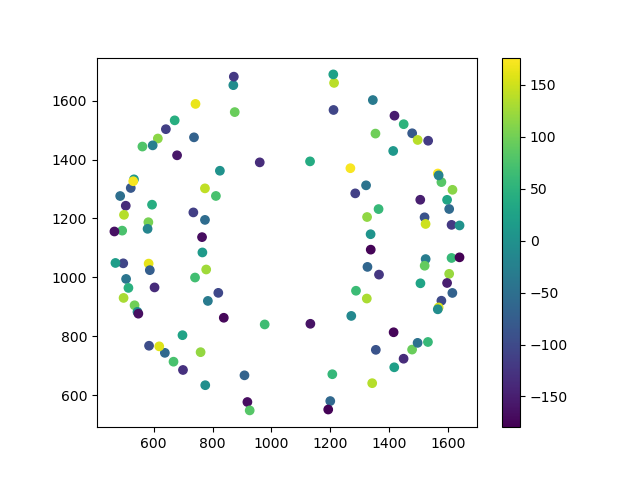

In [42]:
fig, ax = plt.subplots()
scat = ax.scatter(fc, sc, c=omega)
ax.set_aspect(1)
plt.colorbar(scat)
plt.show()

In [28]:
# ok so ImageD11 works
# now we need to

In [29]:
# peaks -> gvecs -> assign to rings -> score all pairs

In [30]:
def _g_to_ds(gvec):
    # compute d-star from g-vector
    # it's just the length
    ds = jnp.linalg.norm(gvec)
    return ds

g_to_ds = jax.jit(jax.vmap(_g_to_ds))

In [31]:
assert np.allclose(g_to_ds(gve), idx.ds)

In [32]:
# maybe simpler way
# get the distance from each peak to each ring
# for each peak, take the closest ring if it's within error

In [33]:
struc.ringds

array([0.49205989, 0.56818182, 0.80353043, 0.94222295, 0.98411978])

In [34]:
struc.ringhkls

{0.49205988851388555: array([[-1., -1., -1.],
        [ 1.,  1.,  1.],
        [-1., -1.,  1.],
        [ 1.,  1., -1.],
        [-1.,  1.,  1.],
        [ 1., -1., -1.],
        [ 1., -1.,  1.],
        [-1.,  1., -1.]]),
 0.5681818181818182: array([[ 0.,  2.,  0.],
        [-2.,  0.,  0.],
        [ 0., -2.,  0.],
        [ 0.,  0., -2.],
        [ 2.,  0.,  0.],
        [ 0.,  0.,  2.]]),
 0.8035304331665312: array([[-2.,  2.,  0.],
        [-2.,  0., -2.],
        [ 2.,  0., -2.],
        [ 2.,  0.,  2.],
        [ 0.,  2., -2.],
        [ 0.,  2.,  2.],
        [-2., -2.,  0.],
        [-2.,  0.,  2.],
        [ 0., -2.,  2.],
        [ 2., -2.,  0.],
        [ 0., -2., -2.],
        [ 2.,  2.,  0.]]),
 0.9422229518055113: array([[-1., -3., -1.],
        [-1., -3.,  1.],
        [-3., -1.,  1.],
        [ 3., -1.,  1.],
        [ 3., -1., -1.],
        [ 3.,  1., -1.],
        [-3.,  1.,  1.],
        [-1.,  1., -3.],
        [ 1.,  1.,  3.],
        [-1.,  3.,  1.],
        [-1.,

In [46]:
@jax.jit
def assign_peaks_to_rings(ds, ringds, ds_tol):
    # (npks, nrings)
    dists = jnp.abs(ds[:, None] - ringds[None, :])

    # index of closest ring (npks,)
    ring_assignments = jnp.argmin(dists, axis=1)

    # gather distances to assigned rings
    min_dists = jnp.take_along_axis(dists, ring_assignments[:, None], axis=1)[:, 0]

    # apply tolerance mask
    return jnp.where(min_dists < ds_tol, ring_assignments, -1)

# @jax.jit
# def assign_peaks_to_rings(ds, ringds, ds_tol):
#     # (npks, nrings)
#     dists = jnp.abs(ds[:, None] - ringds[None, :])

#     # index of closest ring (npks,)
#     ring_assignments = jnp.argmin(dists, axis=1)

#     # minimum distances (npks,)
#     min_dists = jnp.min(dists, axis=1)

#     # mask outside tolerance
#     return jnp.where(min_dists < ds_tol, ring_assignments, -1)

In [47]:
ra = assign_peaks_to_rings(g_to_ds(gve), struc.ringds, idx.ds_tol)

In [48]:
ra

Array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [49]:
idx.ra

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [39]:
assert np.allclose(ra, idx.ra)